<h2>2<sup>η</sup> ΕΡΓΑΣΤΗΡΙΑΚΗ ΑΣΚΗΣΗ</h2>
<h3>Ανάλυση Κοινωνικής Δομής σε Τεχνητές και Πραγματικές Σύνθετες Τοπολογίες Δικτύων</h3>
<p style=text-align:justify>Στην παρούσα άσκηση θα αναλυθούν τεχνητές και πραγματικές τοπολογίες σύνθετων δικτύων με βάση τις μετρικές που χρησιμοποιήθηκαν στην προηγούμενη άσκηση και κάποιες τεχνικές που έχουν ως στόχο την εύρεση κοινωνικής δομής. Συγκεκριμένα, θα χρησιμοποιηθούν και θα συγκριθούν διάφοροι αλγόριθμοι εντοπισμού κοινοτήτων σε γράφους δικτύων που προκύπτουν από πραγματικά δεδομένα καθώς και στους συνθετικούς γράφους της πρώτης εργαστηριακής άσκησης.</p>

In [1]:
%matplotlib inline

import itertools
import random
import textwrap
import time
from datetime import datetime

import joblib
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy as sp
import seaborn as sns
from sklearn.cluster import SpectralClustering
from tabulate import tabulate
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 10)
matplotlib.rcParams["figure.dpi"] = 300
sns.set_palette('cubehelix')
sns.set()

Βοηθητικές Συναρτήσεις:

In [2]:
get_values = lambda metric, G: list(metric(G).values())
fancy_tabulate = lambda table, headers: tabulate(
    table, headers, tablefmt="fancy_grid")


def plot_histplot(metric_dict, xlabel):
    fig, axs = plt.subplots(4, 2)

    for (name, values), ax in zip(metric_dict.items(), fig.axes):
        sns.histplot(values, ax=ax, kde=True)
        ax.axvline(np.mean(values), linestyle='--')
        ax.set_title(name)
        ax.set_xlabel(xlabel)
    plt.tight_layout()

<h3>Α. Μελέτη πραγματικών τοπολογιών</h3>
<p style=text-align:justify>Στο παρόν ερώτημα θα μελετήσετε και θα αποκτήσετε αίσθηση της τοπολογικής δομής πραγματικών δικτύων. Πιο συγκεκριμένα, για τις τοπολογίες που φαίνονται στον <b>πίνακα 1</b>, να βρεθούν και να δειχθούν:</p>
<ol>
    <li>Η κατανομή του βαθμού κόμβου και ο μέσος βαθμός κάθε τοπολογίας.</li>
    <li>Η κατανομή του συντελεστή ομαδοποίησης κόμβου και ο μέσος συντελεστής ομαδοποίησης κάθε τοπολογίας.</li>
    <li>Η κατανομή της κεντρικότητας εγγύτητας και η μέση κεντρικότητα εγγύτητας κάθε τοπολογίας.</li>
</ol>
<p style=text-align:justify>Να συγκριθούν τα αποτελέσματα σε σχέση με αυτά των συνθετικών τοπολογιών. Να χαρακτηρίσετε τον τύπο κάθε μίας από τις πραγματικές τοπολογίες με βάση τους τύπους δικτύων που εξετάστηκαν στην πρώτη εργαστηριακή άσκηση.</p>

<table style=width:100%>
    <caption>Πίνακας <b>1</b>: Πραγματικές τοπολογίες</a></caption>
<tr>
    <th style=text-align:left>Τοπολογία</th>
    <th style=text-align:left>Αρχείο</th>
    <th style=text-align:left>Περιγραφή</th>
</tr>
<tr>
    <td style=text-align:left>American College Football</td>
    <td style=text-align:left><a style=text-decoration:none href='http://www-personal.umich.edu/~mejn/netdata/football.zip'>football.gml</a></td>
    <td style=text-align:left><p style=text-align:justify> The file <b>football.gml</b> contains the network of American football games between Division IA colleges during regular season Fall 2000, as compiled by M. Girvan and M. Newman. The nodes have values that indicate to which conferences they belong.</p>
    </td>
</tr>  
<tr>
    <td style=text-align:left>Game of Thrones - season 5</td>
    <td style=text-align:left><a style=text-decoration:none href='https://networkofthrones.wordpress.com/the-series/season-5/'>GoT</a></td>
    <td style=text-align:left><p style=text-align:justify> The season 5 <b>GoT</b> network represents the interactions between the characters of Game of Thrones in season 5. The season 5 network has 118 nodes (characters) and 394 weighted edges, corresponding to 5,139 interactions. Data can be found here: <a style=text-decoration:none href='https://raw.githubusercontent.com/mathbeveridge/gameofthrones/master/data/got-s5-edges.csv'>GoT_data</a></p>
</tr> 
<tr>
    <td style=text-align:left>email-Eu-core</td>
    <td style=text-align:left><a style=text-decoration:none href='https://snap.stanford.edu/data/email-Eu-core.html'>email-eu-core</a></td>
    <td style=text-align:left><p style=text-align:justify> The network <b>email-Eu-core</b> was generated using email data from a large European research institution. There is an edge (u, v) in the network if person u sent person v at least one email. The e-mails only represent communication between institution members (the core) and the dataset does not contain incoming messages from or outgoing messages to the rest of the world. The dataset also contains "ground-truth" community memberships of the nodes. Each individual belongs to exactly one of 42 departments at the research institute. </p>
</tr> 
    
</table>

<h4>Παραγωγή συνθετικών τοπολογιών</h4> 
<p>Προσοχή! Τα δίκτυα που θα παράξετε θα πρέπει να είναι συνδεδεμένα.</p>

In [3]:
n = 80
d = 4
M = 300
R = 0.25
p = 0.3
k = 4
seedno = 5
random.seed(seedno)

REG = nx.watts_strogatz_graph(n=n, k=k, p=0, seed=seedno)
RGER = nx.gnm_random_graph(n=n, m=M, seed=seedno)
RGG = nx.random_geometric_graph(n=n, radius=R, seed=seedno)
SF = nx.barabasi_albert_graph(n=n, m=d, seed=seedno)
SW = nx.watts_strogatz_graph(n=n, k=k, p=p, seed=seedno)

topologies = {"REG": REG, "RGER": RGER, "RGG": RGG, "SF": SF, "SW": SW}

for name, G in topologies.items():
    assert nx.is_connected(G), "{} should be a connected graph".format(name)

<h4>Εισαγωγή και οπτικοποίηση πραγματικών τοπολογιών.</h4>

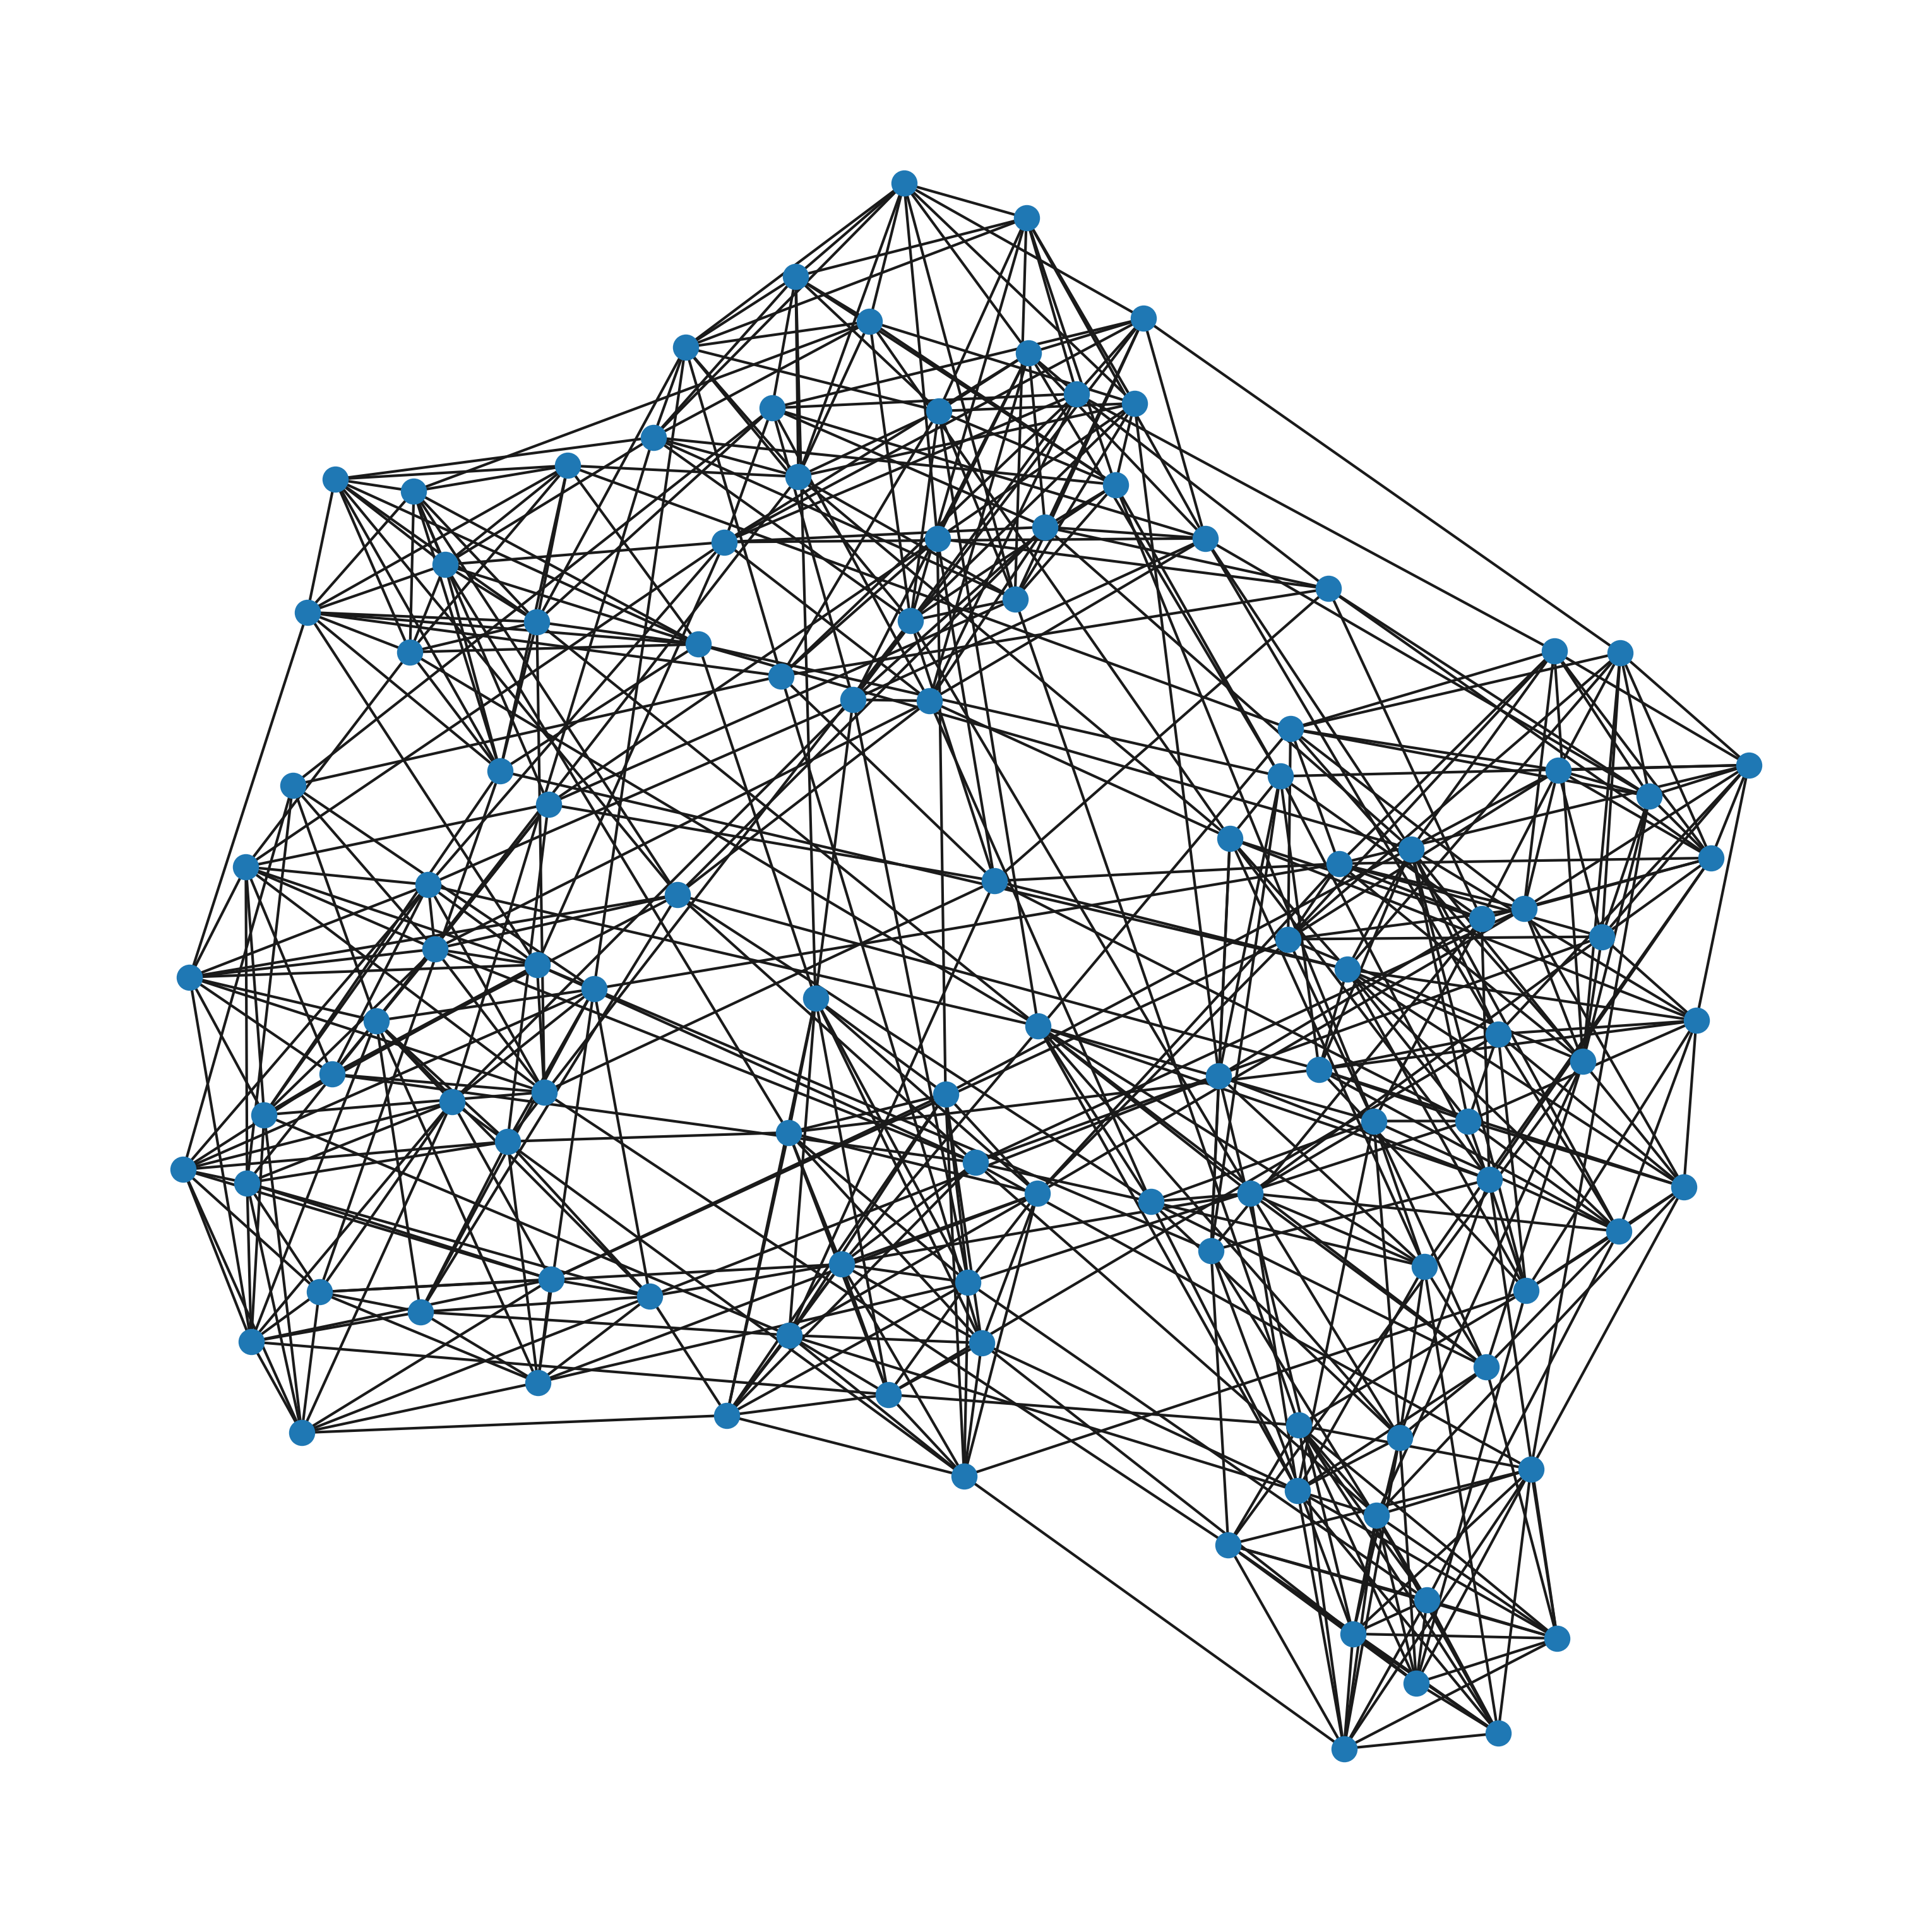

In [4]:
#football network
football = nx.read_gml(r"football.gml")
topologies['Football'] = football
nx.draw(football, node_size=80)

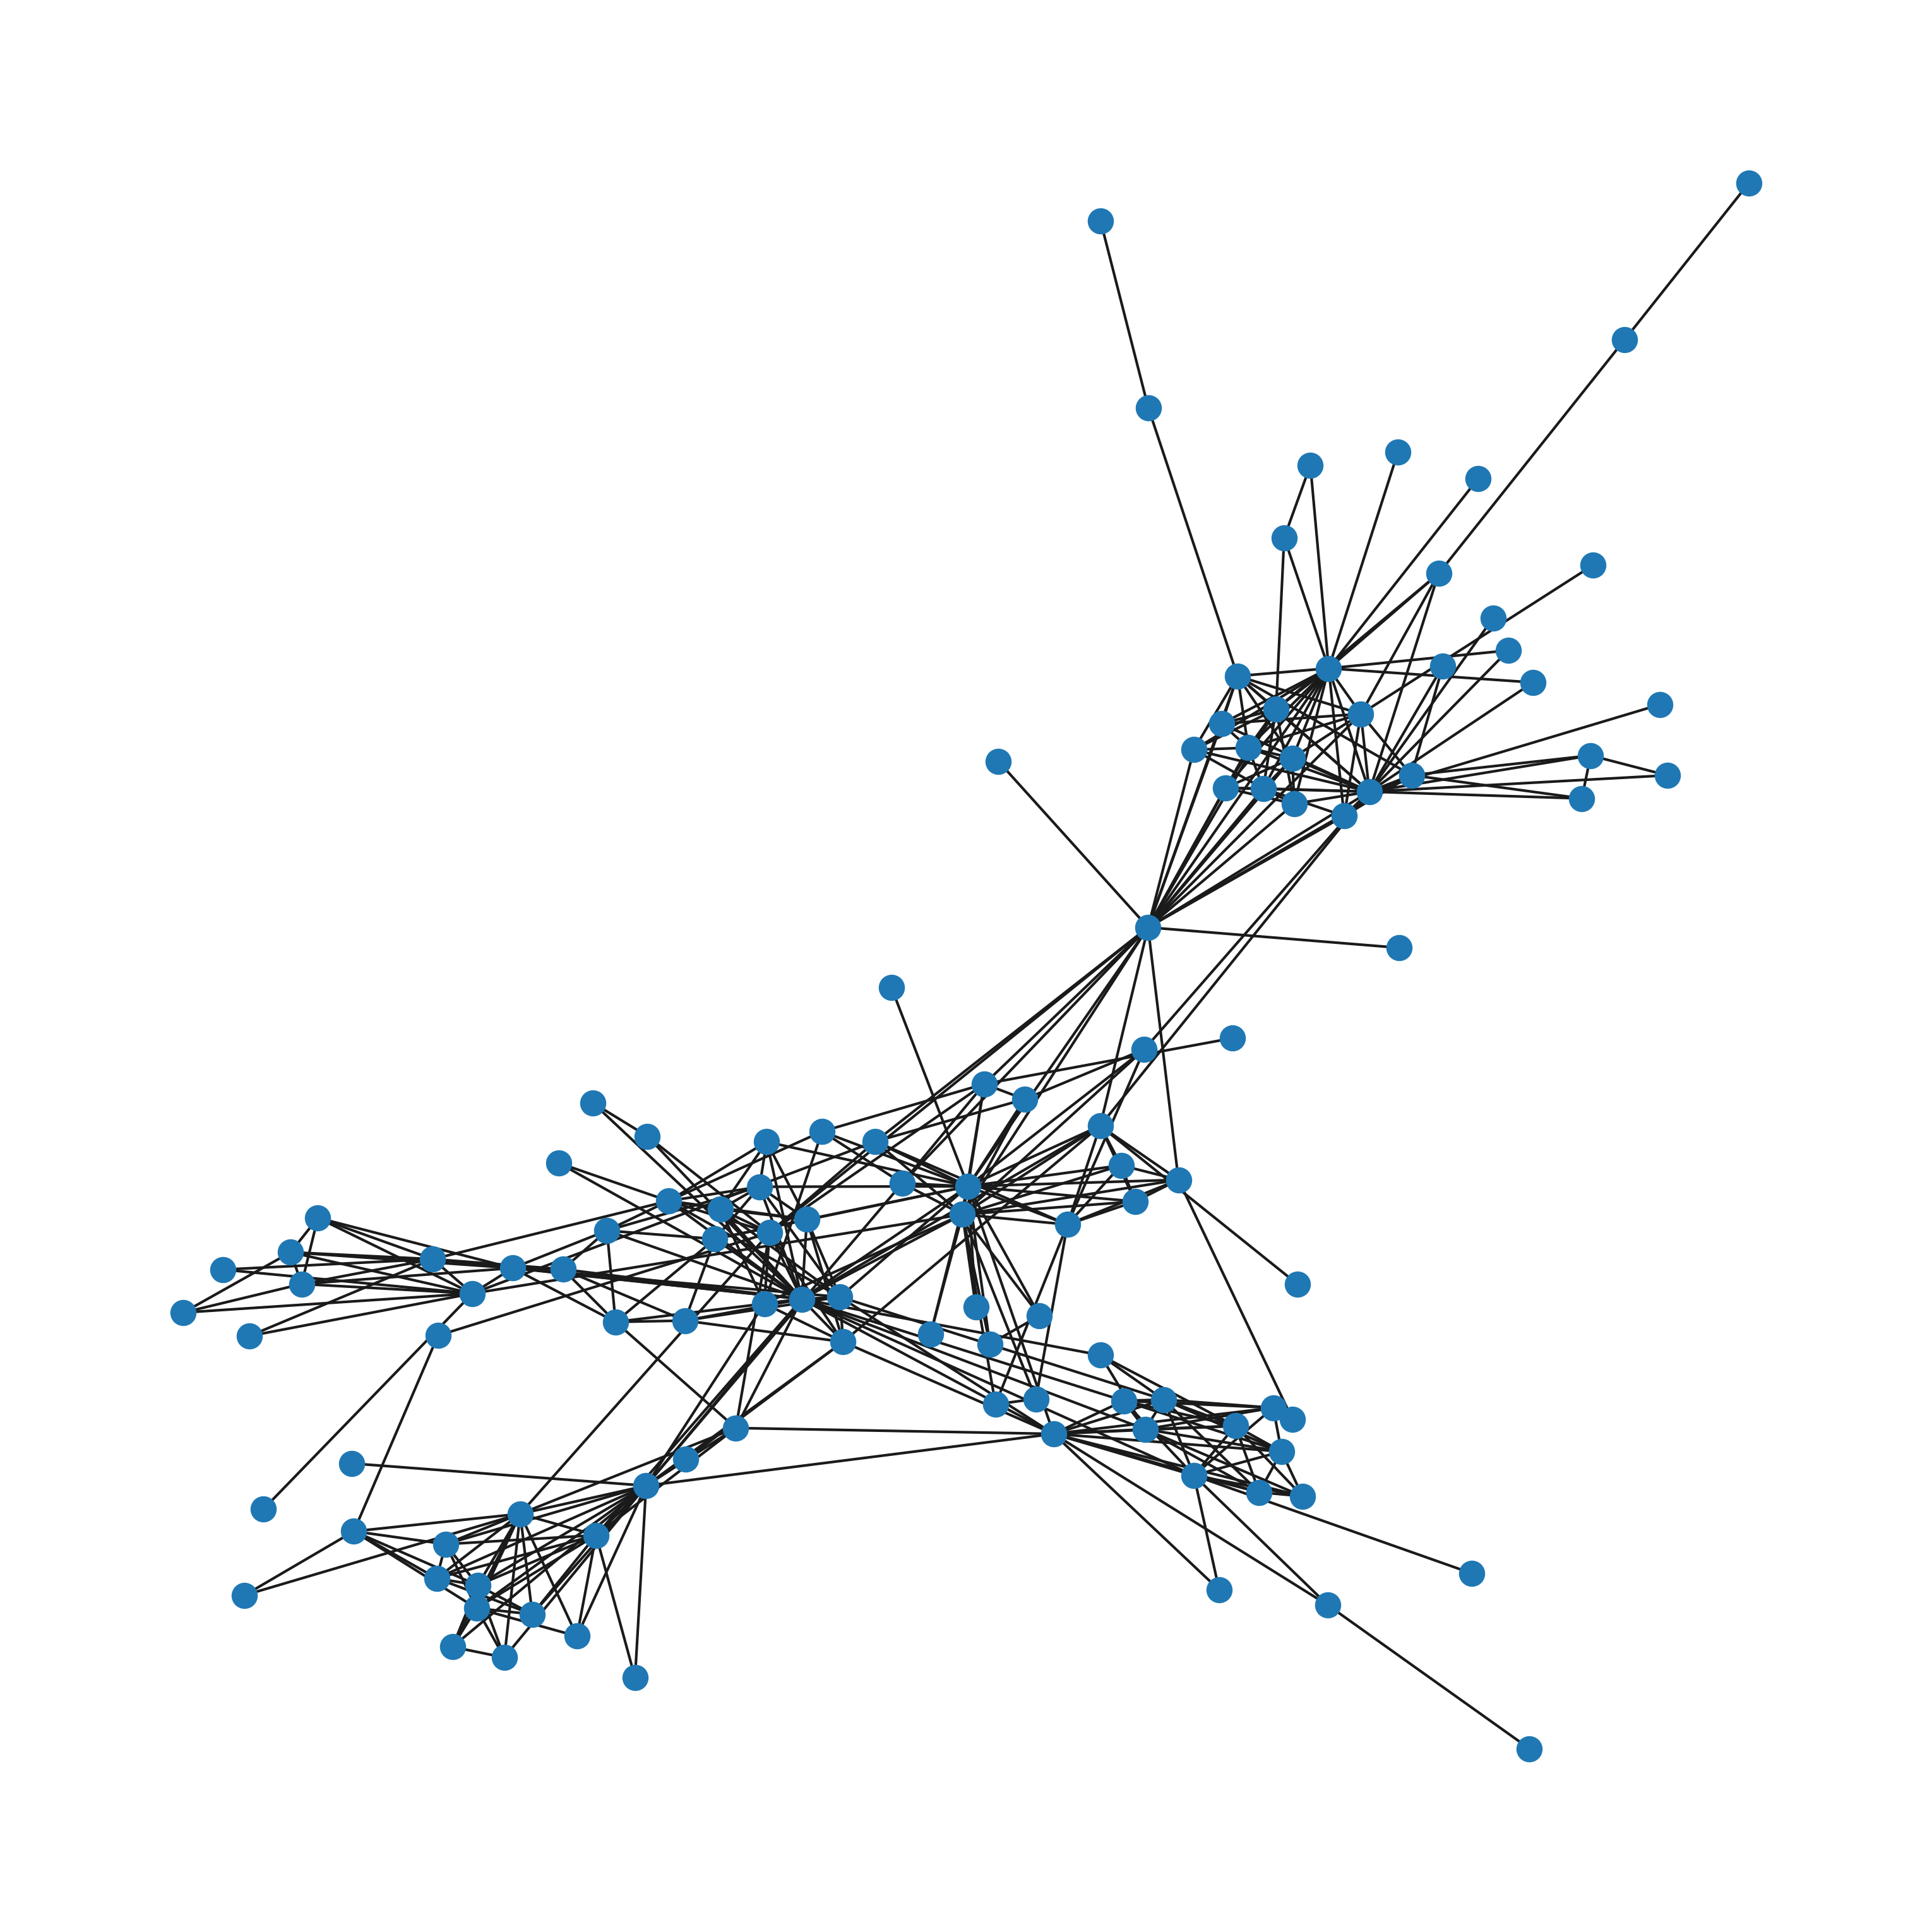

In [5]:
#Game of thrones network
import csv

got = nx.Graph()
with open('got_s5.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    next(csv_reader)
    for row in csv_reader:
        got.add_edge(row[0], row[1])
        line_count += 1
topologies['Game of Thrones'] = got
nx.draw(got, node_size=80)

#### Προσοχή! Θα μελετήσετε τη μεγαλύτερη συνδεδεμένη συνιστώσα του δικτύου email-Eu-core, αφού πρώτα αφαιρέσετε τα self-loops. Μπορείτε να κάνετε χρήση των συναρτήσεων connected_components, subgraph, remove_edges_from του networkx.

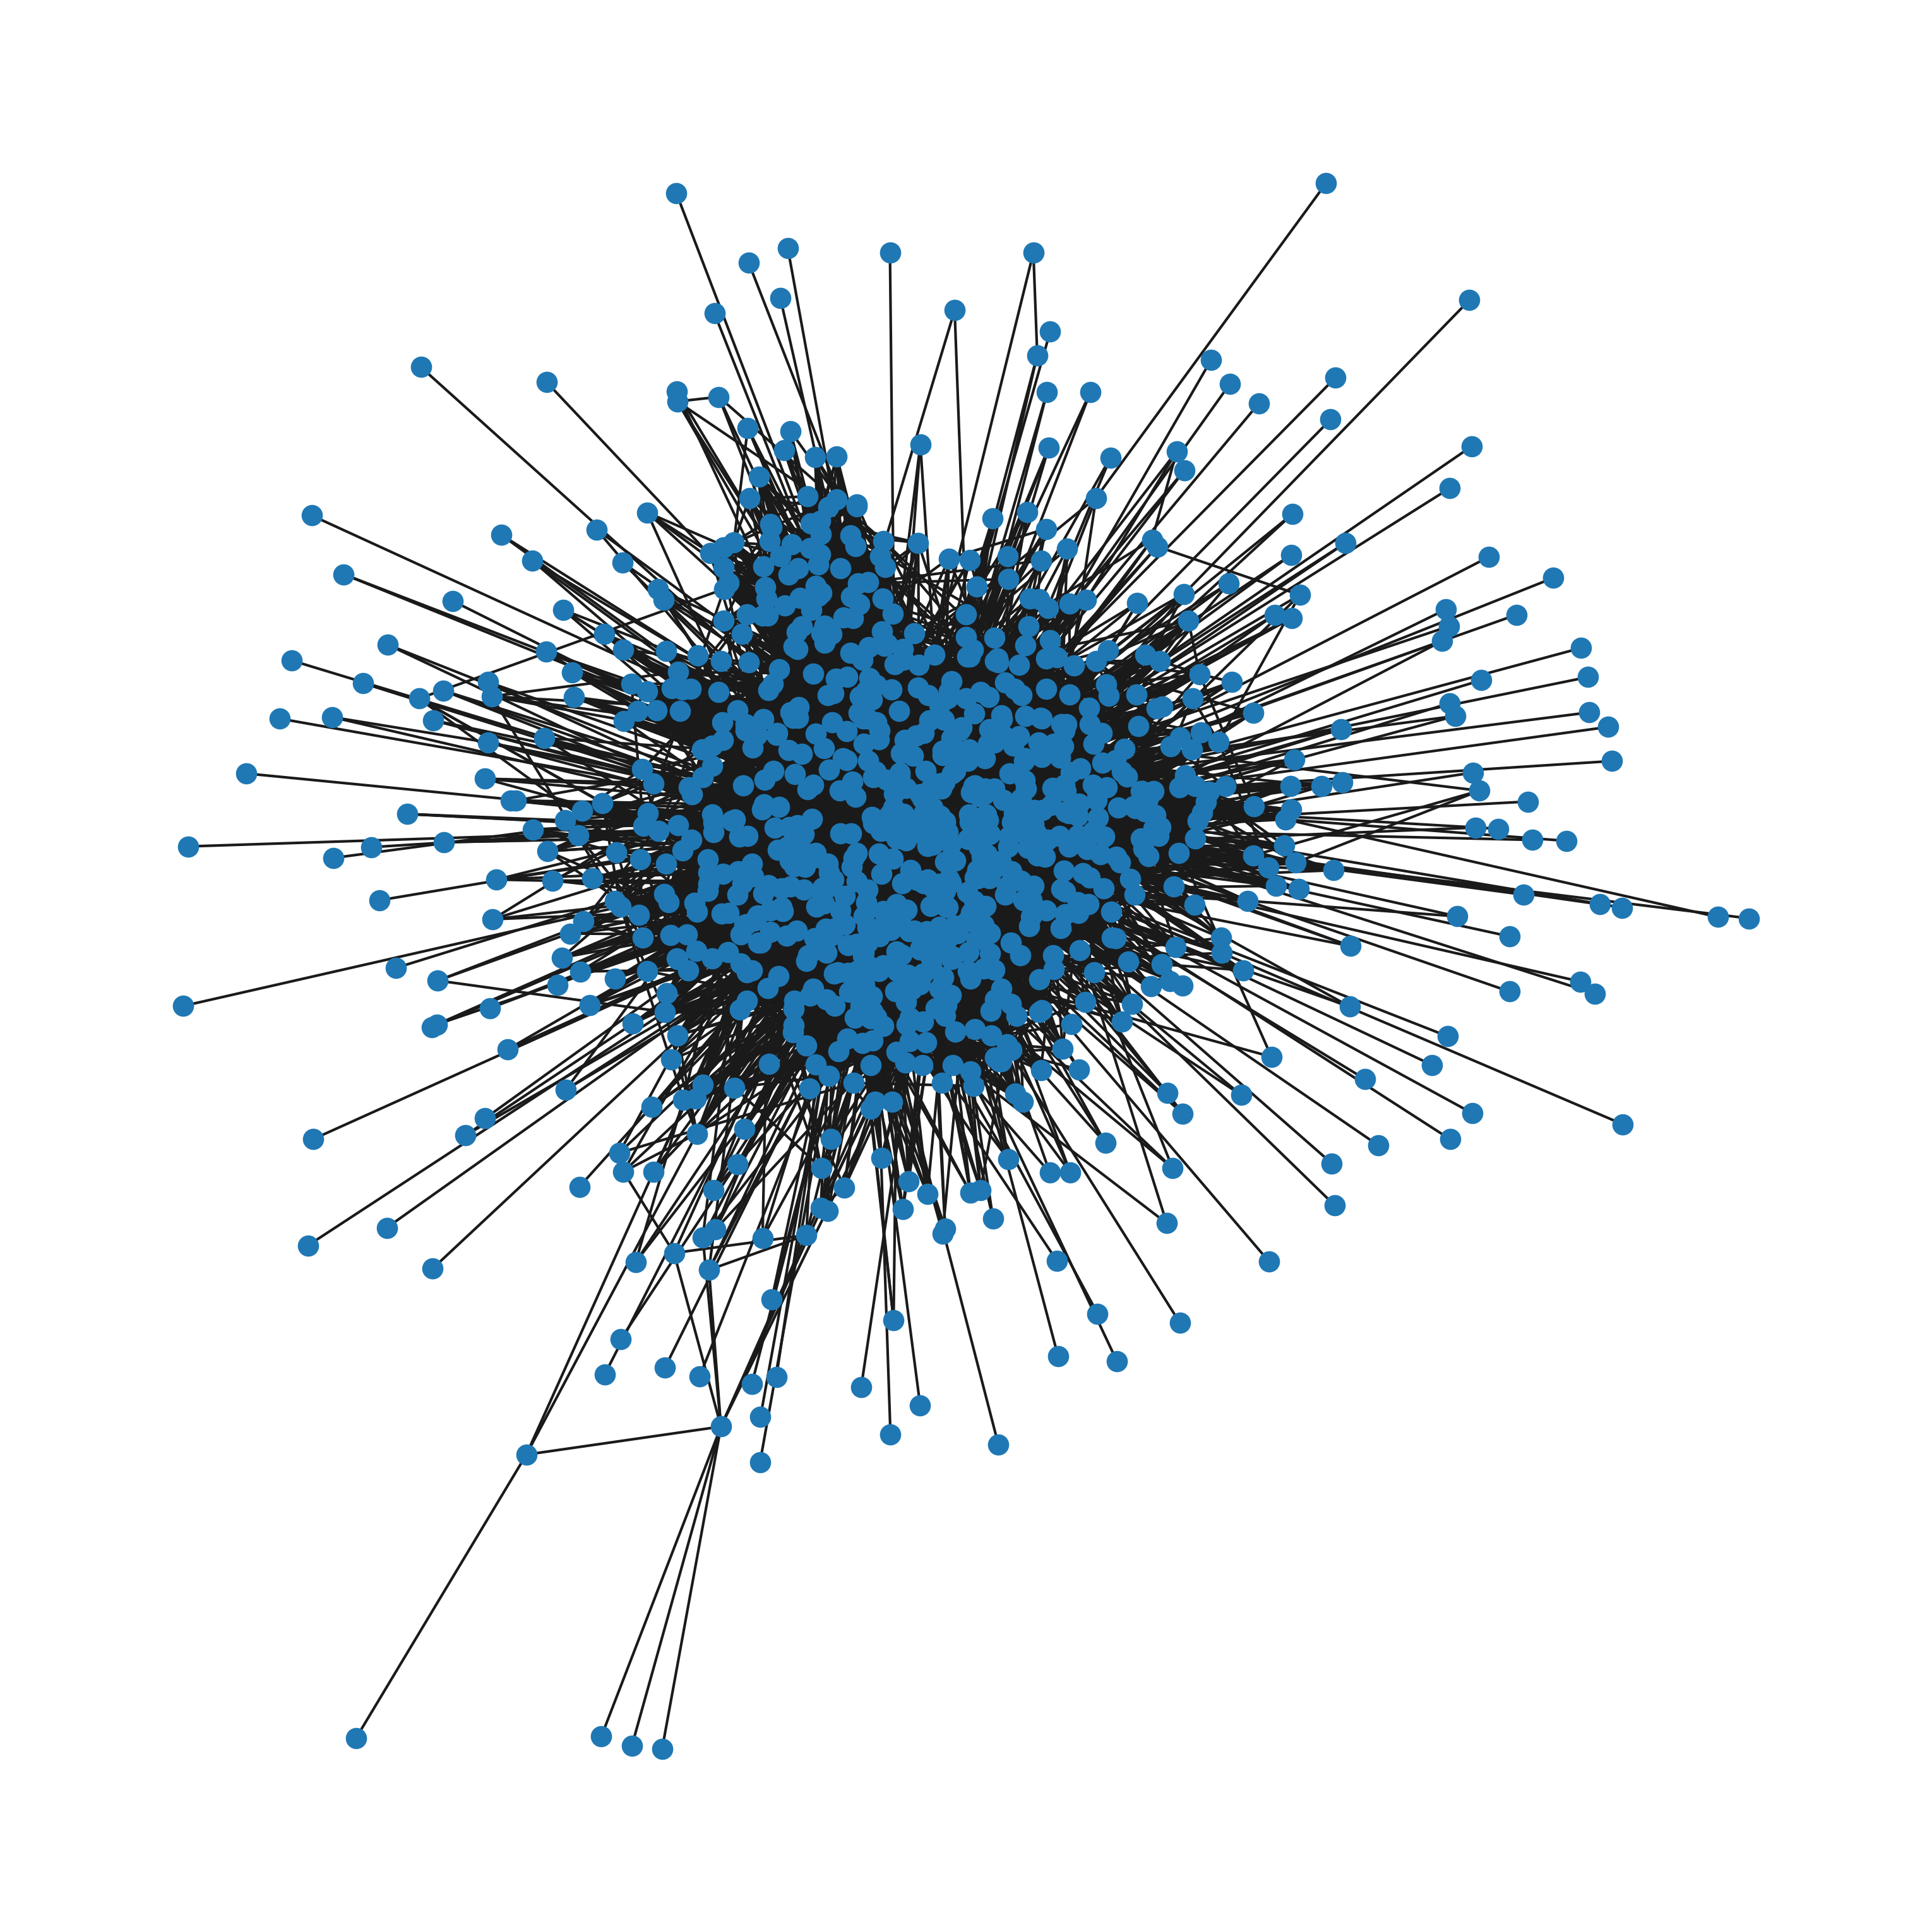

In [6]:
#email-Eu-core network
eu = nx.read_edgelist("email-Eu-core.txt", create_using=nx.Graph())

eu.remove_edges_from(nx.selfloop_edges(eu))
largest_cc = max(nx.connected_components(eu),
                 key=len)  # code from documentation of nx.connected components
eu = eu.subgraph(largest_cc)
topologies['EU email'] = eu
nx.draw(eu, node_size=50)

<h4>Μελέτη βαθμού κόμβου για πραγματικές και συνθετικές τοπολογίες.</h4>

In [7]:
def find_degree(G):
    return dict(G.degree())


degrees_of_topologies = {
    name: get_values(find_degree, G) for name, G in topologies.items()
}

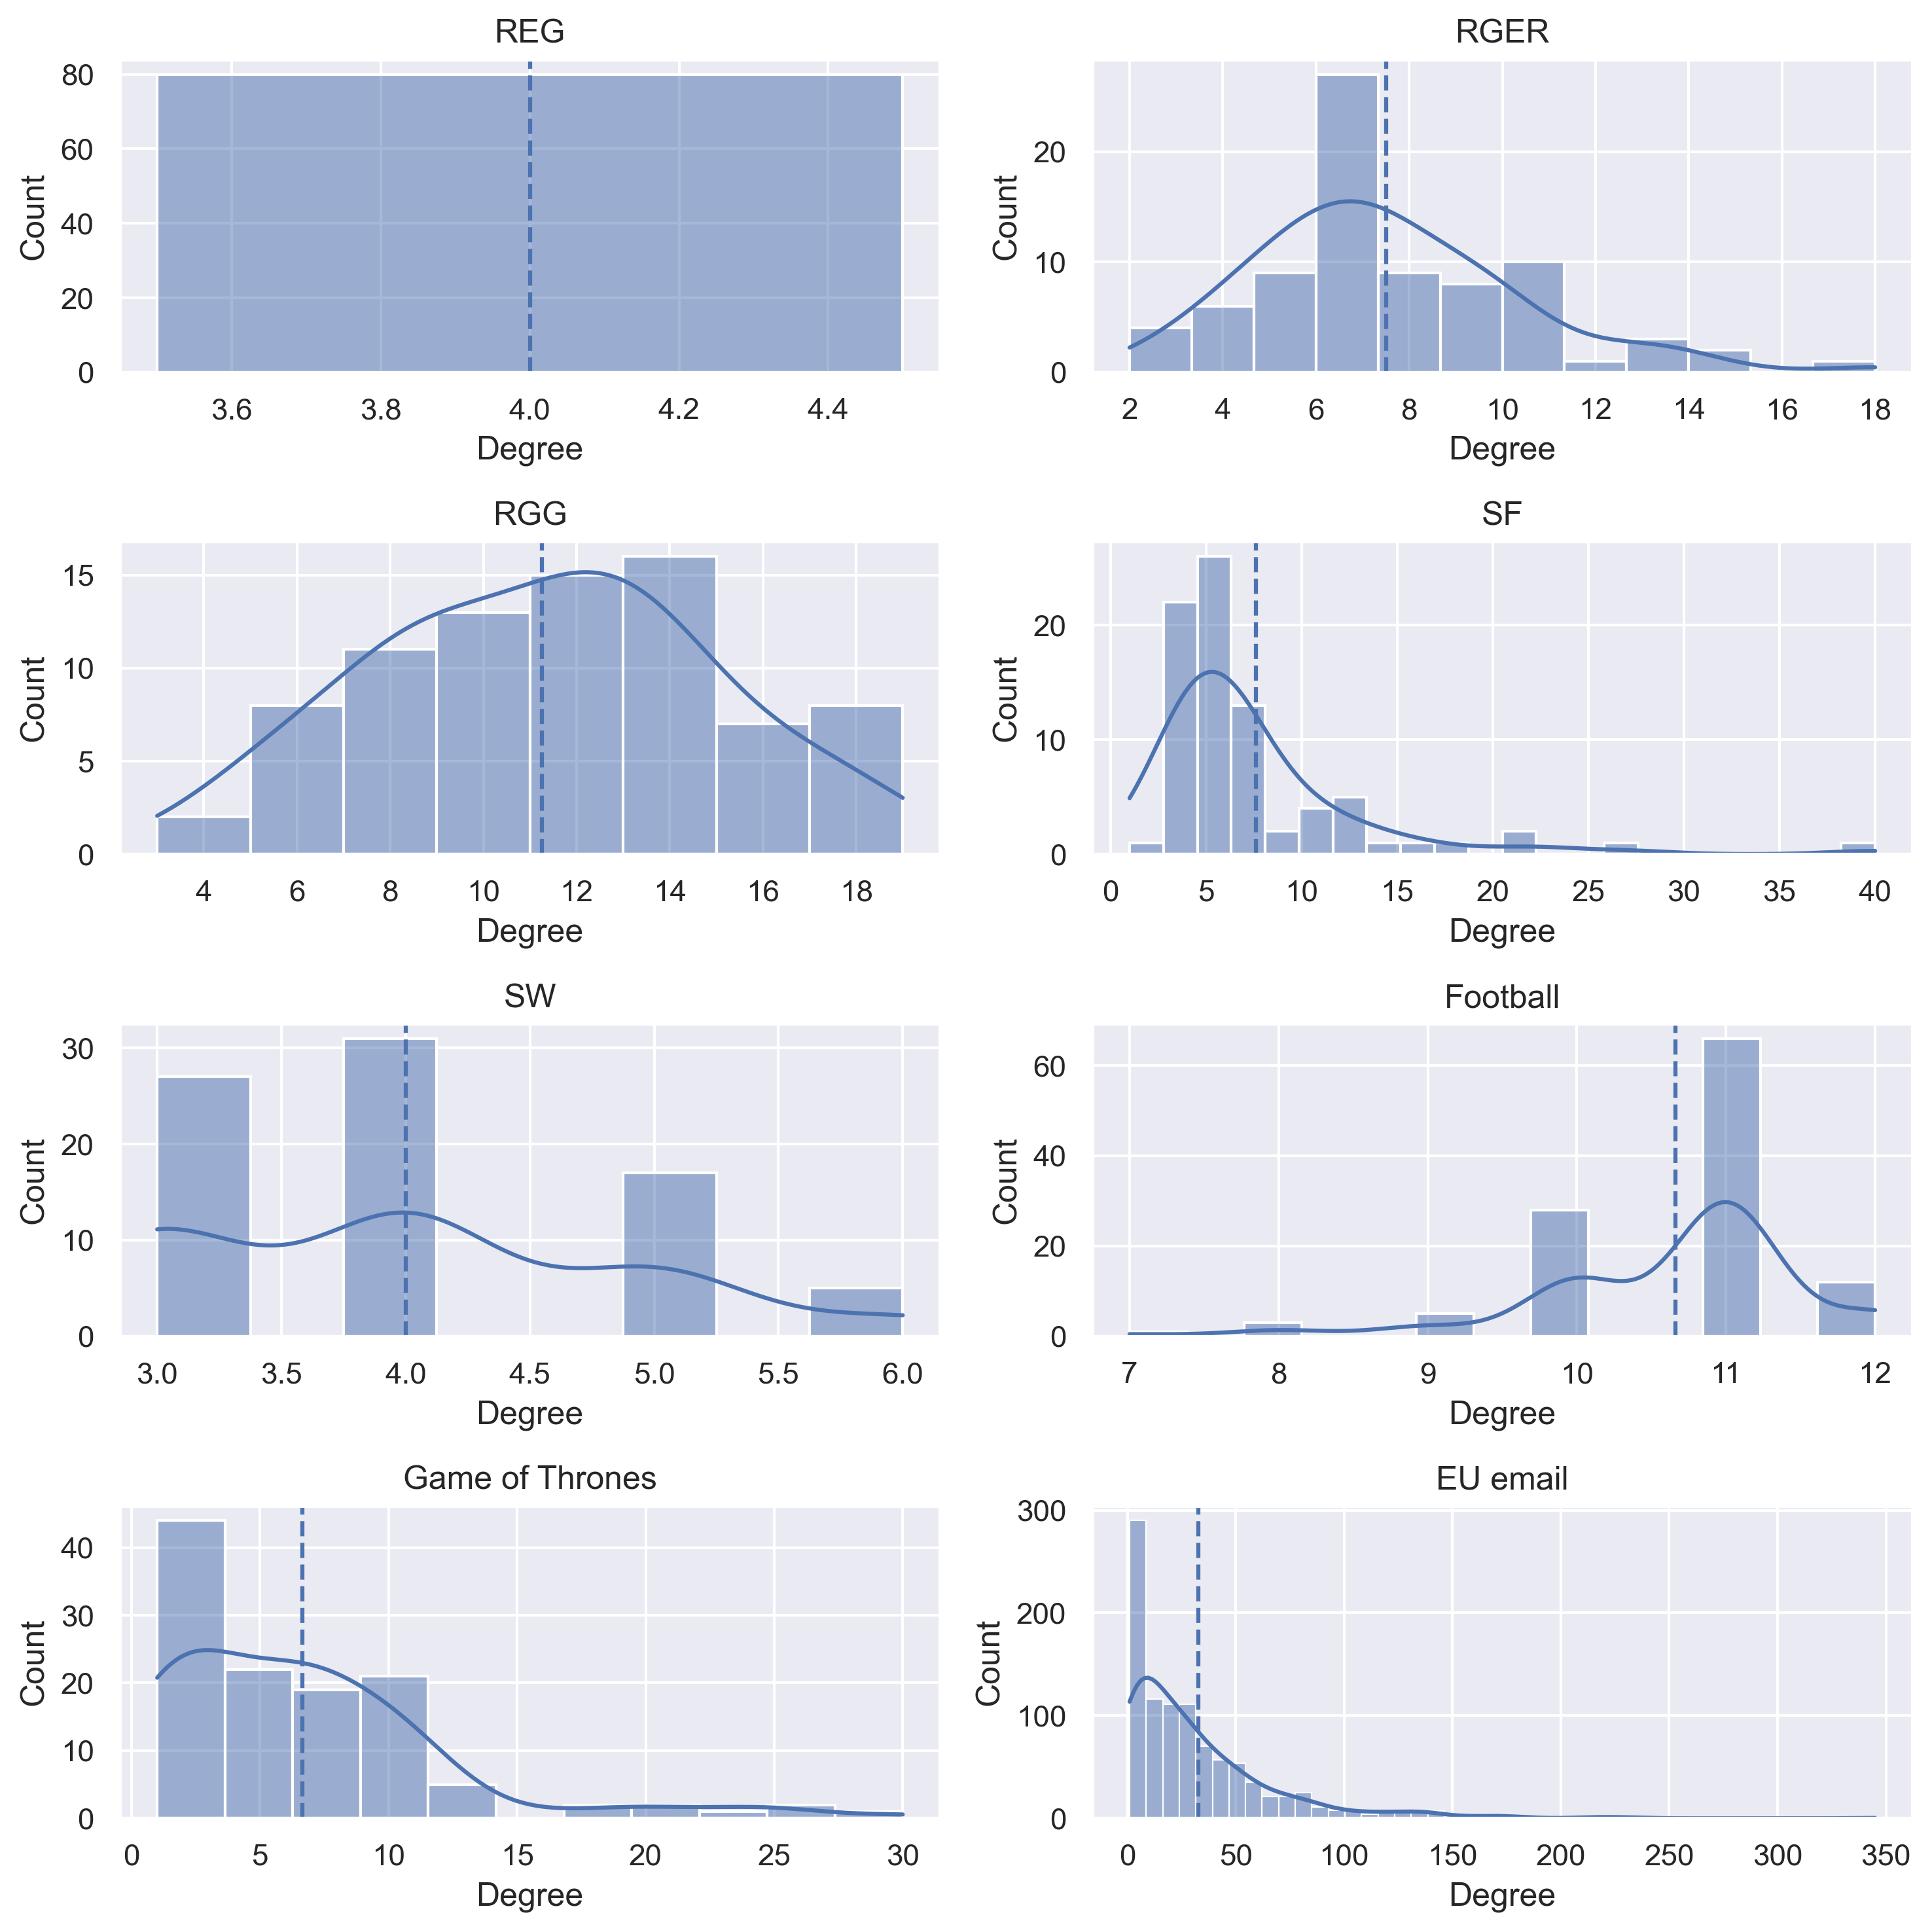

In [8]:
plot_histplot(degrees_of_topologies, "Degree")

In [9]:
table = [[name, np.mean(values), np.var(values)]
         for name, values in degrees_of_topologies.items()]
headers = ["Topology", "Mean Degree", "Variance"]
print(fancy_tabulate(table, headers))

╒═════════════════╤═══════════════╤═════════════╕
│ Topology        │   Mean Degree │    Variance │
╞═════════════════╪═══════════════╪═════════════╡
│ REG             │       4       │    0        │
├─────────────────┼───────────────┼─────────────┤
│ RGER            │       7.5     │    8.15     │
├─────────────────┼───────────────┼─────────────┤
│ RGG             │      11.25    │   13.6625   │
├─────────────────┼───────────────┼─────────────┤
│ SF              │       7.6     │   33.39     │
├─────────────────┼───────────────┼─────────────┤
│ SW              │       4       │    0.8      │
├─────────────────┼───────────────┼─────────────┤
│ Football        │      10.6609  │    0.780643 │
├─────────────────┼───────────────┼─────────────┤
│ Game of Thrones │       6.65546 │   31.0494   │
├─────────────────┼───────────────┼─────────────┤
│ EU email        │      32.5842  │ 1370.89     │
╘═════════════════╧═══════════════╧═════════════╛


<h4>Μελέτη συντελεστή ομαδοποίησης για πραγματικές και συνθετικές τοπολογίες</h4>

In [10]:
def cc(G):
    return nx.clustering(G)


cc_of_topologies = {name: get_values(cc, G) for name, G in topologies.items()}

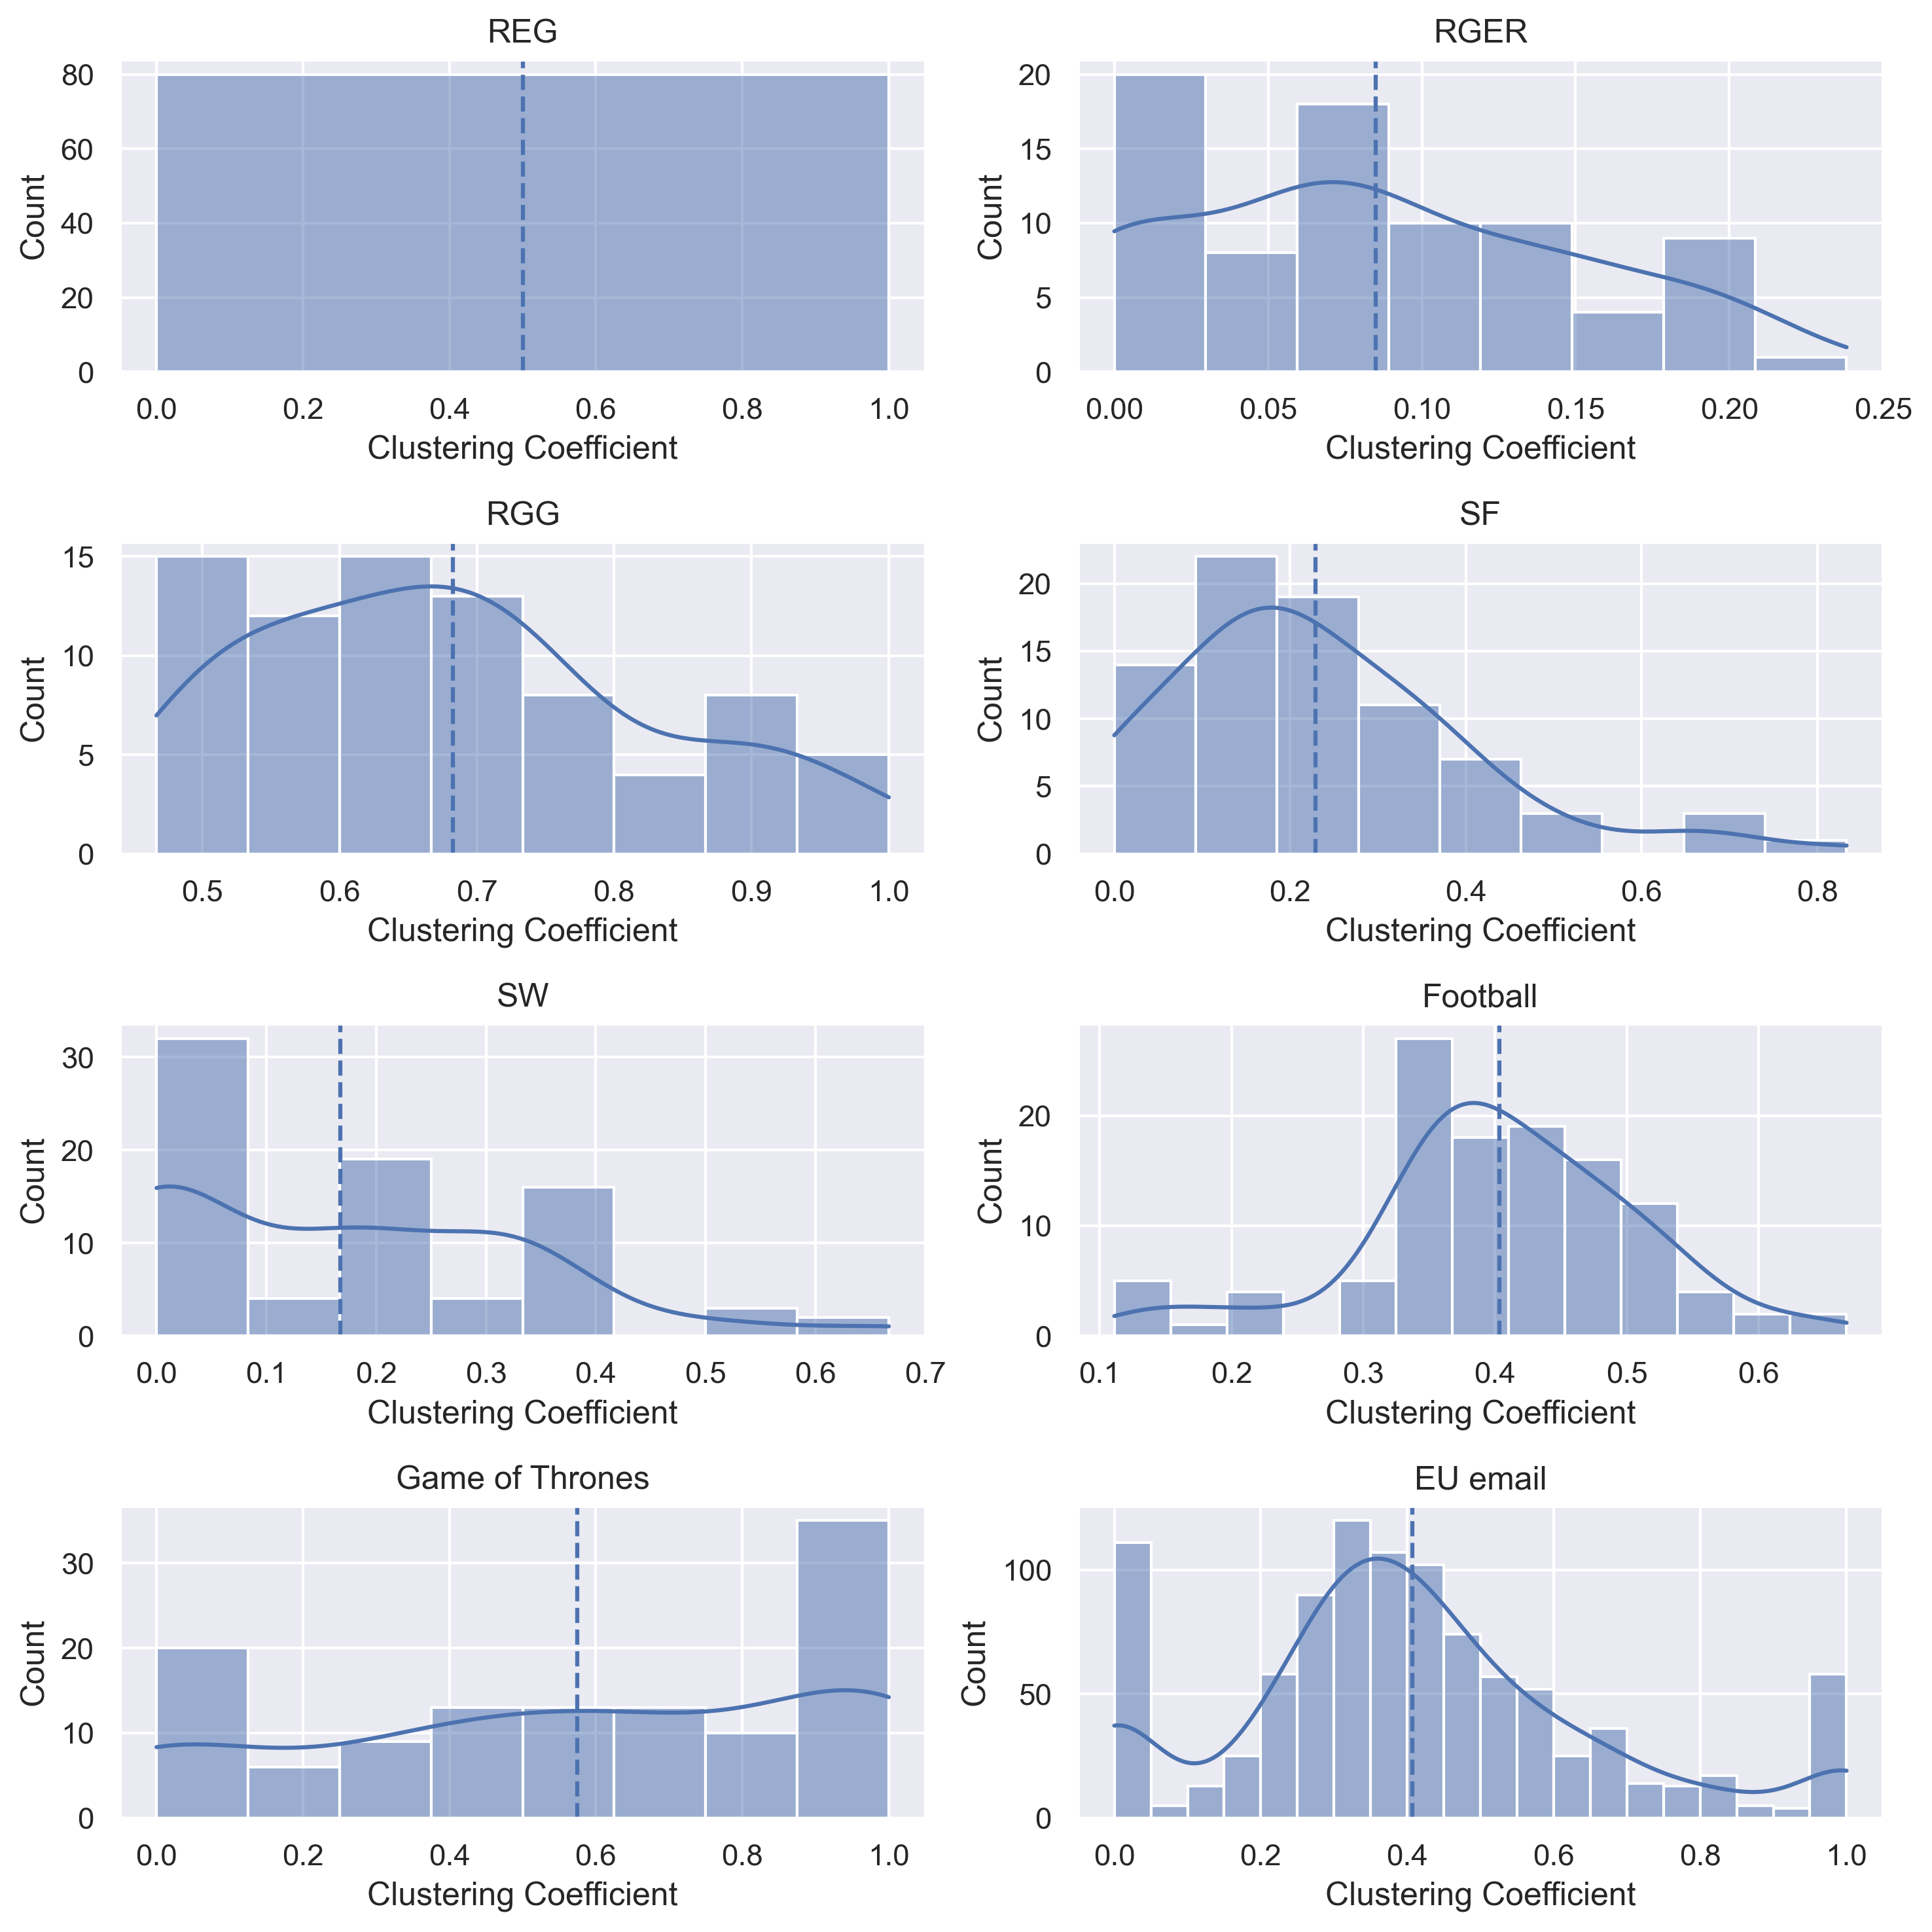

In [11]:
plot_histplot(cc_of_topologies, "Clustering Coefficient")

In [12]:
table = [[name, np.mean(values), np.var(values)]
         for name, values in cc_of_topologies.items()]
headers = ["Topology", "Mean Clustering Coefficient", "Variance"]
print(fancy_tabulate(table, headers))

╒═════════════════╤═══════════════════════════════╤════════════╕
│ Topology        │   Mean Clustering Coefficient │   Variance │
╞═════════════════╪═══════════════════════════════╪════════════╡
│ REG             │                     0.5       │ 0          │
├─────────────────┼───────────────────────────────┼────────────┤
│ RGER            │                     0.0849778 │ 0.00428887 │
├─────────────────┼───────────────────────────────┼────────────┤
│ RGG             │                     0.682579  │ 0.0206504  │
├─────────────────┼───────────────────────────────┼────────────┤
│ SF              │                     0.229228  │ 0.0289289  │
├─────────────────┼───────────────────────────────┼────────────┤
│ SW              │                     0.167083  │ 0.0280693  │
├─────────────────┼───────────────────────────────┼────────────┤
│ Football        │                     0.403216  │ 0.0107675  │
├─────────────────┼───────────────────────────────┼────────────┤
│ Game of Thrones │      

<h4>Μελέτη κεντρικότητας εγγύτητας για πραγματικές και συνθετικές τοπολογίες </h4>

In [13]:
def find_closeness(G):
    return nx.closeness_centrality(G)


closeness_of_topologies = {
    name: get_values(find_closeness, G) for name, G in topologies.items()
}

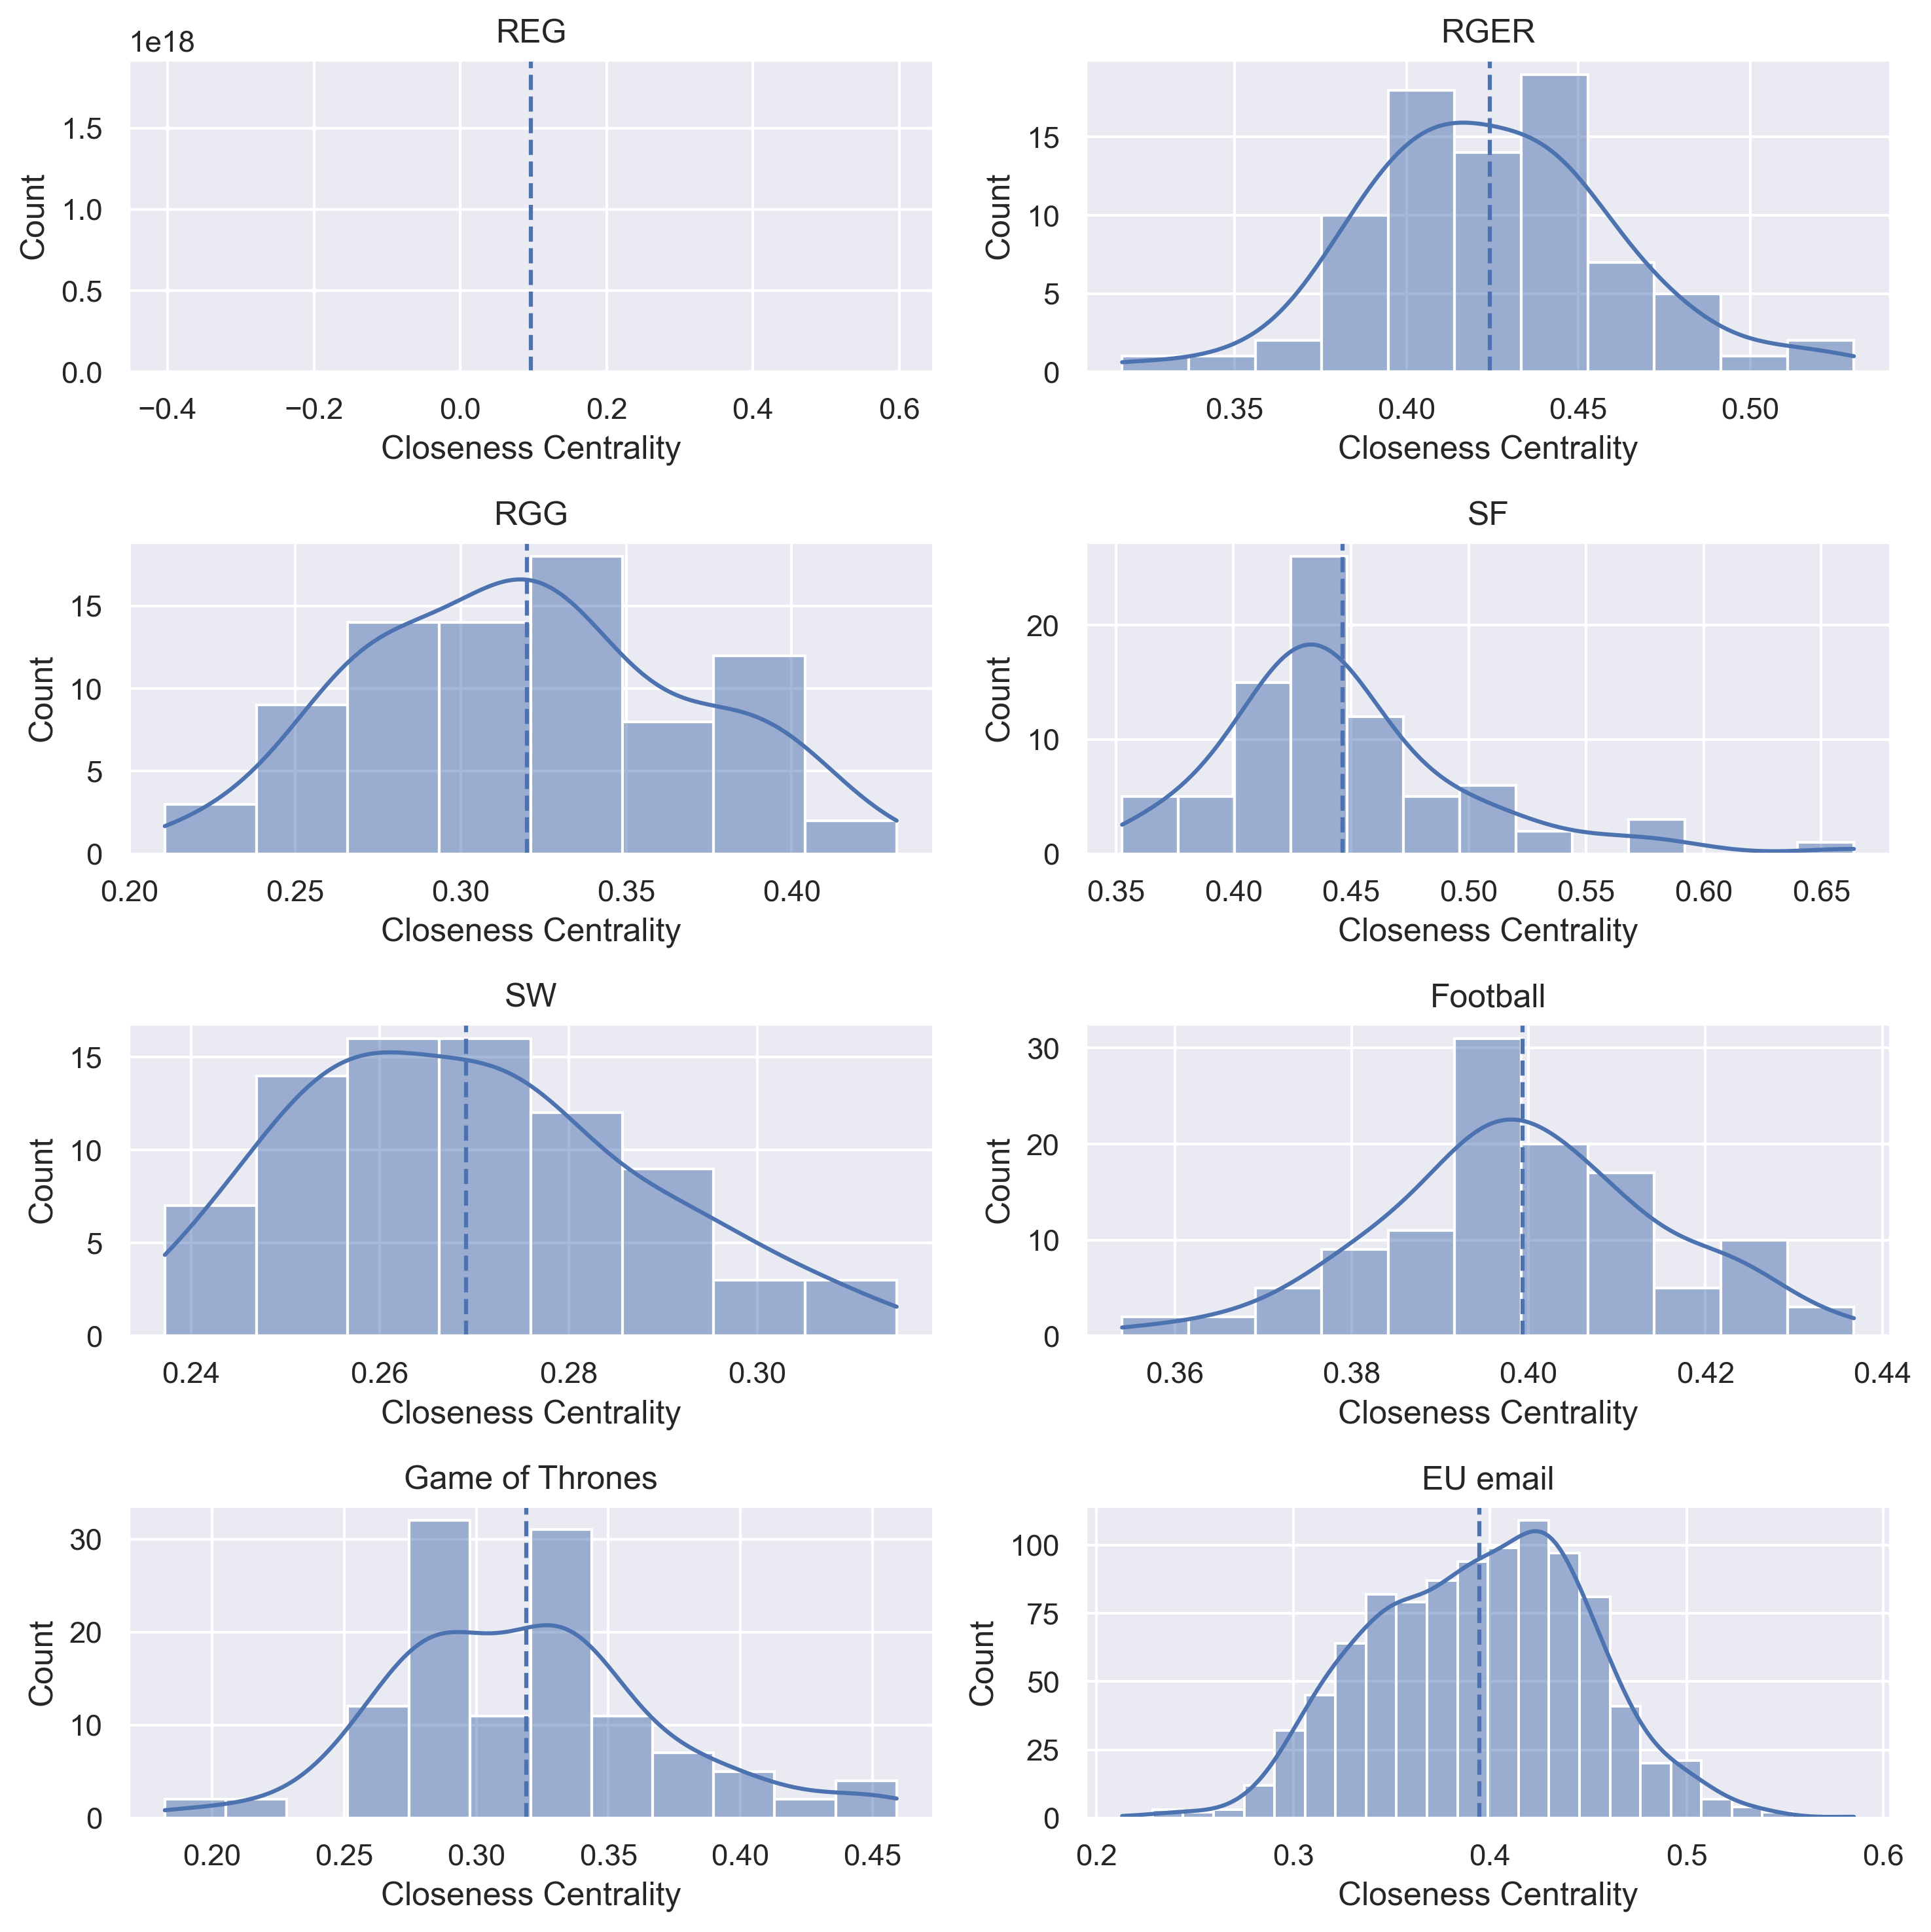

In [14]:
plot_histplot(closeness_of_topologies, "Closeness Centrality")

In [15]:
table = [[name, np.mean(values), np.var(values)]
         for name, values in closeness_of_topologies.items()]
headers = ["Topology", "Mean Closeness Centrality", "Variance"]
print(fancy_tabulate(table, headers))

╒═════════════════╤═════════════════════════════╤═════════════╕
│ Topology        │   Mean Closeness Centrality │    Variance │
╞═════════════════╪═════════════════════════════╪═════════════╡
│ REG             │                   0.0963415 │ 1.92593e-34 │
├─────────────────┼─────────────────────────────┼─────────────┤
│ RGER            │                   0.42423   │ 0.00136724  │
├─────────────────┼─────────────────────────────┼─────────────┤
│ RGG             │                   0.320088  │ 0.00235292  │
├─────────────────┼─────────────────────────────┼─────────────┤
│ SF              │                   0.446445  │ 0.00274403  │
├─────────────────┼─────────────────────────────┼─────────────┤
│ SW              │                   0.269143  │ 0.000320118 │
├─────────────────┼─────────────────────────────┼─────────────┤
│ Football        │                   0.399319  │ 0.000246165 │
├─────────────────┼─────────────────────────────┼─────────────┤
│ Game of Thrones │                   0.

<h3>B. Εξοικείωση με τα εργαλεία εντοπισμού κοινοτήτων</h3>
<ol>
<li>Χρησιμοποιώντας τις συναρτήσεις του <b>πίνακα 2</b> για κάθε <u>πραγματικό</u> (<b>πίνακας 1</b>) και <u>συνθετικό</u> (από την <b>άσκηση 1</b>) δίκτυο:</p>
<ol>
    <li>να οπτικοποιηθούν οι κοινότητες που προκύπτουν από την κάθε μέθοδο,</li>
    <li>να γίνουν οι απαραίτητοι σχολιασμοί (π.χ: σύγκριση του αριθμού των κοινοτήτων που υπολογίζει ο κάθε αλγόριθμος).</li>
</ol>
<p>Για την οπτικοποίηση, να επισημανθεί διαφορετικά κάθε κοινότητα, π.χ. με διαφορετικό χρώμα.</p>
<p style=text-align:justify>Στην περίπτωση των συνθετικών δικτύων, να πραγματοποιηθούν συγκρίσεις και μεταξύ των διαφορετικών τύπων τοπολογιών. Για παράδειγμα, στην περίπτωση του τυχαίου γεωμετρικού γράφου, υπάρχει διαισθητικά μία κοινότητα γύρω από κάθε κόμβο που δημιουργείται με βάση τις αποστάσεις του τελευταίου από τους υπόλοιπους κόμβους του δικτύου. Στην περίπτωση των scale-free δικτύων, είναι πιθανό να σχηματίζονται κοινότητες γύρω από τους κόμβους με μεγάλο βαθμό.</p>
<li>Για κάθε αλγόριθμο εντοπισμού κοινοτήτων και για κάθε τοπολογία αξιολογήστε την ποιότητα της διαμέρισης με τις μετρικές performance και modularity (<a style=text-decoration:none href='https://networkx.org/documentation/stable/reference/algorithms/community.html#module-networkx.algorithms.community.quality'>measuring_partitions</a>). Για την μετρική performance, θα χρησιμοποιήσετε την συνάρτηση partition_quality του networkx.</li>
<li>Για την μεγαλύτερη συνδεδεμένη συνιστώσα του email-Eu-core, να συγκρίνετε την ground-truth διαμέριση που δίνεται στο αρχείο Email-Eu-core-department-labels.txt με τις διαμερίσεις που προκύπτουν από τις εξεταζόμενες μεθόδους ως προς το πλήθος των παραγόμενων κοινοτήτων και ως προς τις μετρικές performance και modularity. </li>
<li>Για την παρακολούθηση του χρόνου εκτέλεσης της υλοποίησής σας, μπορείτε να χρησιμοποιήσετε την βιβλιοθήκη <a style=text-decoration:none href='https://tqdm.github.io/'>tqdm</a>. Στο σχολιασμό σας να λάβετε υπόψη το trade-off της ποιότητας της διαμέρισης και του χρόνου εκτέλεσης των εξεταζόμενων αλγορίθμων. </li>
</ol>

<table style=float:left;width:70%>
    <caption>Πίνακας <b>2</b>: Συναρτήσεις εντοπισμού κοινοτήτων</caption>
    <tr>
        <th style=text-align:left> Μέθοδος εντοπισμού κοινοτήτων</th>
        <th style=text-align:left>Συνάρτηση</th>
    </tr>
    <tr>
        <td style=text-align:left>Spectral Clustering</td>
        <td style=text-align:left><a style=text-decoration:none href='http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html'>SpectralClustering</a></td>
    </tr>
       <tr>
        <td style=text-align:left>Newman-Girvan</td>
        <td style=text-align:left><a style=text-decoration:none                               href='https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html'>girvan_newman</a></td>
    </tr>
    <tr>
        <td style=text-align:left>Modularity Maximization</td>
        <td style=text-align:left><a style=text-decoration:none                               href='https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html'>greedy_modularity_communities</a></td>
    </tr>
</table>
    

<p style=text-align:justify>Προτού εφαρμόσετε τις συναρτήσεις εντοπισμού κοινοτήτων μελετήστε προσεκτικά την <b>είσοδο που απαιτούν καθώς και τη μορφή εξόδου που παράγουν.</b></p>

In [16]:
#Χρησιμοποιήστε την συνάρτηση conv2int για να μετατρέψετε τα labels των κόμβων στις πραγματικ΄ές τοπολογίες σε integers
def conv2int(G, start_value):
    nG = nx.convert_node_labels_to_integers(G, first_label=start_value)
    G_mapping = dict(enumerate(G.nodes, 0))
    return nG, G_mapping

In [17]:
topologies['Football'], football_map = conv2int(topologies['Football'], 0)
topologies['Game of Thrones'], got_map = conv2int(topologies['Game of Thrones'],
                                                  0)
topologies['EU email'], eu_email_map = conv2int(topologies['EU email'], 0)

<h4> Ορισμός χρωμάτων για την οπτικοποίηση των κοινοτήτων.</h4>

In [18]:
#insert colors for nodes
from matplotlib import colors as mcolors

colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())

<h4>Εντοπισμός κοινοτήτων σε συνθετικά και πραγματικά δίκτυα με τη μέθοδο Newman-Girvan.</h4>
<p>Παράξτε τις διαμερίσεις που προκύπτουν από την μέθοδο Newman-Girvan. Ελέγξτε τις διαμερίσεις που έχουν μέχρι και 50 κοινότητες.</p> 
<p> Επιλέξτε τις διαμερίσεις με το 1) μεγαλύτερο modularity score και 2) performance score για κάθε πραγματικό και συνθετικό δίκτυο.</p>

In [19]:
metrics = {
    "modularity":
        lambda G, c: nx.algorithms.community.quality.modularity(G, c),
    "performance":
        lambda G, c: nx.algorithms.community.quality.partition_quality(G, c)[1]
}


def get_metrics(topology, metric, limited, time):
    new_start = datetime.now()
    return_data = {
        "topology": topology,
        "max_metric": metric,
    }
    best_community = max(limited,
                         key=lambda c: metrics[metric](topologies[topology], c))

    return_data['best_partition'] = best_community
    for mname, mmetric in metrics.items():
        return_data[mname] = mmetric(topologies[topology], best_community)
    elapsed_time = datetime.now() - new_start
    return_data['elapsed_time'] = elapsed_time + time
    pbar.update(0.5)
    return return_data


def girvan_newman(topology, k=50):
    start = datetime.now()
    comp = nx.algorithms.community.centrality.girvan_newman(
        topologies[topology])
    limited = list(itertools.takewhile(lambda c: len(c) <= k,
                                       comp))  # from documentation
    pbar.update(1)
    elapsed_time = datetime.now() - start
    metric_results = []
    for metric in metrics.keys():
        metric_results.append(
            get_metrics(topology, metric, limited, elapsed_time))
    return metric_results

In [ ]:
iter_product = list(topologies.keys())
table = []

with tqdm(total=len(iter_product) * 2) as pbar:
    for topology in iter_product:
        table.extend(girvan_newman(topology, k=50))

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
def partitions2string(partitions):
    string = []
    for part_dict in partitions:
        result = []
        lst = list(part_dict)
        for k, g in itertools.groupby(enumerate(lst), lambda x: x[0] - x[1]):
            g = list(map(lambda x: x[1], g))
            if len(g) > 1:
                result.append([g[0], g[-1]])
            else:
                result.append([g[0]])
        print(result)
        partition_string = []
        for i in result:
            if len(i) == 1:
                partition_string.append(i[0])
            else:
                partition_string.append('{} - {}'.format(i[0], i[1]))
        string.append(", ".join(partition_string))

partitions2string(table[0]['best_partition'])

In [ ]:
table_best_modularity = [[
    res['topology'], res['modularity'], res['elapsed_time'],
    "\n\n".join([textwrap.fill(str(di), 130) for di in res['best_partition']])
] for res in filter(lambda x: x['max_metric'] == 'modularity', table)]
headers = ['Topology', 'Max Modularity', "Elapsed Time", "Partition"]

print(fancy_tabulate(table_best_modularity, headers))

In [ ]:
table_best_modularity = [[
    res['topology'], res['performance'], res['elapsed_time'],
    "\n\n".join([textwrap.fill(str(di), 120) for di in res['best_partition']])
] for res in filter(lambda x: x['max_metric'] == 'performance', table)]
headers = ['Topology', 'Max Performance', "Elapsed Time", "Partition"]

print(fancy_tabulate(table_best_modularity, headers))

In [ ]:
node_mapping = dict((v,k) for k,v in eu_email_map.items())
eu_communities_ground_truth = {}
with open("./email-Eu-core-department-labels.txt") as f:
    for line in f:
        numbers = [x for x in line.split()]
        node = numbers[0]
        community_number = int(numbers[1])
        if (node in node_mapping):
            node = node_mapping(node)
            try:
                eu_communities_ground_truth[community_number].add(node)
            except KeyError:
                eu_communities_ground_truth[community_number] = {node}

In [ ]:
[
    mmetric(topologies['EU email'], eu_communities_ground_truth)
    for mmetric in metrics.values()
]

<h4>Εντοπισμός κοινοτήτων σε συνθετικά και πραγματικά δίκτυα με τη μέθοδο Spectral Clustering. </h4>
Προσοχή! Για την επιλογή της τιμής της παραμέτρου που αφορά στην διάσταση του projection subspace (n_clusters) της συνάρτησης SpectralClustering, θα πρέπει να λάβετε υπόψη το μέγεθος |V| του εκάστοτε δικτύου.
<p>Να εξετάσετε τις διαμερίσεις που προκύπτουν για n_clusters$=2,...,|V|$. Να επιλέξετε για οπτικοποίηση τις διαμερίσεις με το 1) μεγαλύτερο modularity score και 2) performance score για κάθε πραγματικό και συνθετικό δίκτυο.</p>

**Διευκρίνιση: Για τον εντοπισμό των κοινοτήτων με την μέθοδο Spectral Clustering, να εξετάσετε τις διαμερίσεις που προκύπτουν για n-clusters=2,3,..,50.**

<h4>Εντοπισμός κοινοτήτων σε συνθετικά και πραγματικά δίκτυα με τη μέθοδο Modularity Maximization.</h4>
Για την διαμέριση που θα προκύψει σε κάθε συνθετικό και πραγματικό δίκτυο, να υπολογίσετε το modularity score και το performance score.

#### Οπτικοποίηση κοινοτήτων American College Football

#### Οπτικοποίηση κοινοτήτων Game of Thrones

#### Οπτικοποίηση κοινοτήτων email-Eu-core (να οπτικοποιηθεί και η ground-truth διαμέριση)

#### Οπτικοποίηση κοινοτήτων REG

#### Οπτικοποίηση κοινοτήτων RGER

#### Οπτικοποίηση κοινοτήτων RGG

#### Οπτικοποίηση κοινοτήτων SW

#### Οπτικοποίηση κοινοτήτων SF